In [1]:
import pandas as pd
import typing as tp
import numpy as np

In [2]:
from tg.grammar_ru import Separator


text = (
    'Это предложение для того, чтобы построить бандл. '
    'Это предложение не для этого. ' 
    'Еще одно предложение, в котором есть запятая. '
    'В этом предложении, как можно заметить, целых две запятые. '
    'В этом предложении есть новый знак препинания: двоеточие. '
    'Тире - еще один знак препинания. '
    ', А вот это предложение начинается с запятой, правда ведь неожиданно?'
)
df = Separator.separate_string(text)
df

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length
0,0,0,0,0,1,Это,ru,3
1,1,0,1,0,1,предложение,ru,11
2,2,0,2,0,1,для,ru,3
3,3,0,3,0,0,того,ru,4
4,4,0,4,0,1,",",punct,1
...,...,...,...,...,...,...,...,...
61,61,6,8,0,1,",",punct,1
62,62,6,9,0,1,правда,ru,6
63,63,6,10,0,1,ведь,ru,4
64,64,6,11,0,0,неожиданно,ru,10


Напишем класс для фильтрации датасета. Будем брать все предложения, в которых содержатся интересующие нас знаки препинания. Будем помечать `is_target` те слова, после которых должен стоять знак препинания.

In [14]:
from tg.projects.alternative.sentence_filterer import SentenceFilterer


class PunctFilterer(SentenceFilterer):
    def __init__(self, symbols: tp.List[str]):
        super().__init__()
        self.symbols = symbols

    def get_targets(self, df: pd.DataFrame) -> pd.Series:
        return (
            df.word.shift(-1).isin(self.symbols) 
            & (df.sentence_id == df.sentence_id.shift(-1))
            & (df.word_type != 'punct')
            )
        

In [15]:
filterer = PunctFilterer([',', ':'])
filterer.filter(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Это,ru,3,False
1,1,0,1,0,1,предложение,ru,11,False
2,2,0,2,0,1,для,ru,3,False
3,3,0,3,0,0,того,ru,4,True
4,4,0,4,0,1,",",punct,1,False
5,5,0,5,0,1,чтобы,ru,5,False
6,6,0,6,0,1,построить,ru,9,False
7,7,0,7,0,0,бандл,ru,5,False
8,8,0,8,0,1,.,punct,1,False
15,15,2,0,0,1,Еще,ru,3,False


In [16]:
from tg.projects.alternative.negative_sampler import NegativeSampler


class EmptyNegativeSampler(NegativeSampler):
    def build_all_negative_samples_from_positive(self, positive_sample: pd.DataFrame) -> tp.List[pd.DataFrame]:
        return []

    def build_negative_sample_from_positive(self, positive_sample: pd.DataFrame) -> pd.DataFrame:
        return None


# Построение бандла

In [42]:
from tg.grammar_ru.common import Loc
from tg.projects.alternative import BundleBuilder, BundleConfig
from tg.projects.alternative import EndingNegativeSampler
from tg.grammar_ru import features

tsa_sampler = EmptyNegativeSampler()
punct_symbols = [',', ':', '-']


config = BundleConfig(
    [
        Loc.corpus_path/'lenta.base.zip',
        Loc.corpus_path/'books.base.zip',
        Loc.corpus_path/'pub.base.zip',
    ],
    PunctFilterer(punct_symbols),
    tsa_sampler,
    [
        features.PyMorphyFeaturizer(),
        # features.SlovnetFeaturizer(),
        # features.SyntaxTreeFeaturizer(),
        # features.SyntaxStatsFeaturizer()
        
    ],
    Loc.bundles_path/'punct/',
)

builder = BundleBuilder(config)

In [18]:
buckets_path = Loc.data_cache_path/'tasks/punct_buckets.parquet'
if not os.path.isfile(buckets_path):
    buckets = builder.compute_buckets()
    buckets.to_parquet(buckets_path)
else:
    buckets = pd.read_parquet(buckets_path)

A Jupyter Widget

In [44]:
np.sum(buckets.len)

161265266

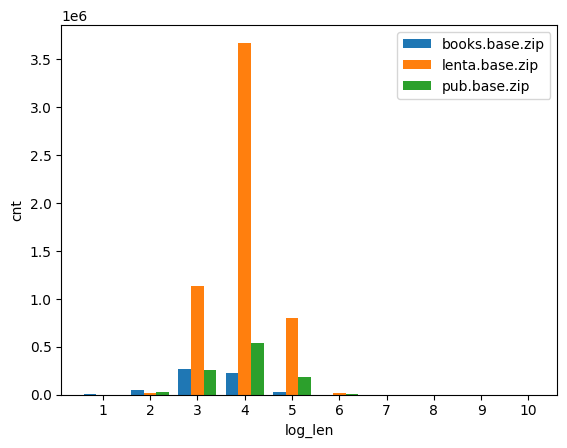

In [24]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

In [30]:
buckets[buckets.corpus_id == 'books.base.zip'].log_len.value_counts()

3    270749
4    225765
2     45490
5     29953
1      1342
6       592
7         6
Name: log_len, dtype: int64

In [34]:
from yo_fluq_ds import *
import numpy as np


take_from_bucket = 150
buckets_trunc = buckets.copy()
buckets_trunc['random'] = np.random.rand(buckets_trunc.shape[0])
buckets_trunc = buckets_trunc.feed(fluq.add_ordering_column(['corpus_id', 'log_len'], 'random'))
buckets_trunc = buckets_trunc.loc[buckets_trunc.order < take_from_bucket]
buckets_trunc.shape[0]

2950

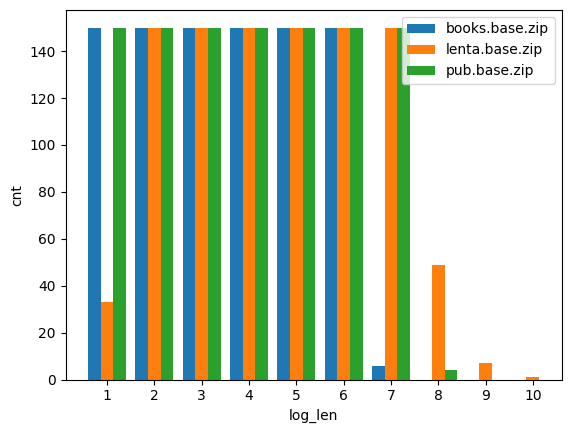

In [35]:
ax = grbar_plot(
    buckets_trunc.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

In [37]:
sum(buckets_trunc.len)

143304

In [43]:
builder.prepare(buckets_trunc)

2023-03-16 20:37:02.522358+00:00 INFO: Processed 553 words. 1/70285
2023-03-16 20:37:02.881839+00:00 INFO: Processed 569 words. 3/70285
2023-03-16 20:37:03.100437+00:00 INFO: Processed 900 words. 4/70285
2023-03-16 20:37:03.302951+00:00 INFO: Processed 1032 words. 5/70285
2023-03-16 20:37:03.521088+00:00 INFO: Processed 1073 words. 6/70285
2023-03-16 20:37:03.705459+00:00 INFO: Processed 1097 words. 7/70285
2023-03-16 20:37:03.889154+00:00 INFO: Processed 1204 words. 8/70285
2023-03-16 20:37:04.112580+00:00 INFO: Processed 1250 words. 10/70285
2023-03-16 20:37:04.454204+00:00 INFO: Processed 1331 words. 12/70285
2023-03-16 20:37:04.678287+00:00 INFO: Processed 1347 words. 14/70285
2023-03-16 20:37:05.258699+00:00 INFO: Processed 1380 words. 18/70285
2023-03-16 20:37:05.425129+00:00 INFO: Processed 1411 words. 19/70285
2023-03-16 20:37:05.737594+00:00 INFO: Processed 1580 words. 21/70285
2023-03-16 20:37:05.888723+00:00 INFO: Processed 1592 words. 22/70285
2023-03-16 20:37:06.389673+00:

In [45]:
builder.featurize()

2023-03-16 20:53:56.991399+00:00 INFO: Processing d8b6969c-7d64-4454-8b44-bda0606d715c at #0, total 3 
2023-03-16 20:53:56.992229+00:00 INFO: <class 'tg.grammar_ru.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-03-16 20:54:03.569348+00:00 INFO: Processing 7579dadb-bf32-4228-9dfd-937e4a7142f2 at #1, total 3 
2023-03-16 20:54:03.570477+00:00 INFO: <class 'tg.grammar_ru.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-03-16 20:54:09.405338+00:00 INFO: Processing a7ad0a87-94ed-40d6-97f8-ef2e64814ce9 at #2, total 3 
2023-03-16 20:54:09.406273+00:00 INFO: <class 'tg.grammar_ru.features.pymorphy_featurizer.PyMorphyFeaturizer'>


In [46]:
builder.assemble(None, Loc.bundles_path/'punct/140k')

A Jupyter Widget

A Jupyter Widget

In [4]:
from tg.common.ml.batched_training import train_display_test_split
from tg.grammar_ru.common import Loc


def build_index(bundle):
    path = Loc.bundles_path/'punct'/bundle
    src = pd.read_parquet(path/'src.parquet')
    print(bundle, src.drop_duplicates('sentence_id').shape[0])
    src['reference'] = src.original_corpus+'/'+src.sentence_id.astype(str)

    shifted_words = src['word'].shift(-1)
    target_words = np.where(
        src['is_target'],
        shifted_words,
        'no'
    )

    index_df = src[['word_id','sentence_id','label','reference']].copy()
    index_df['target_word'] = target_words
    index_df.index.name = 'sample_id'
    index_df['split'] = train_display_test_split(index_df, stratify_column='target_word')
    index_df.to_parquet(path/'index.parquet')

In [59]:
build_index('140k')

140k 2950


In [5]:
import pandas as pd

In [6]:
index_df = pd.read_parquet(Loc.bundles_path/'punct/140k/index.parquet')
# index_df[index_df.split == 'train'].target_word.value_counts()

In [10]:
index_df.target_word.value_counts()

no    129905
,      11333
:       1319
-        747
Name: target_word, dtype: int64